## Preparing images

This notebook uses the example NIfTI from NiBabel's documentation ("`someones_anatomy.nii.gz`") and creates several derived versions of it with different orientations, including oblique physical axes (i.e., the physical axes are rotated w.r.t. the canonical axes of the array), ordering of axes (e.g., RSA), and axis flips (e.g., LAS).

### Preamble
Prepare a Python environment and use a temporal directory for the outputs. After that, fetch the actual file from NiBabel documentation.

In [1]:
%load_ext autoreload
%matplotlib inline

import os
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import nibabel as nb
import nitransforms as nt
from nipype.interfaces.afni import Warp

cwd = TemporaryDirectory()
os.chdir(cwd.name)
print(os.getcwd())

/home/oesteban/.anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


191114-13:19:50,665 nipype.utils INFO:
	 Running nipype version 1.3.0-rc1.post-dev+g2e5436d31 (latest: 1.3.1)
/tmp/tmputw559xm


In [2]:
!wget https://nipy.org/nibabel/_downloads/62985f4c43f499609fa65cb2eb955b79/someones_anatomy.nii.gz

--2019-11-14 13:19:50--  https://nipy.org/nibabel/_downloads/62985f4c43f499609fa65cb2eb955b79/someones_anatomy.nii.gz
Resolving nipy.org (nipy.org)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to nipy.org (nipy.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191449 (187K) [application/gzip]
Saving to: ‘someones_anatomy.nii.gz’

someones_anatomy.ni 100%[===================>] 186.96K  --.-KB/s    in 0.007s  

2019-11-14 13:19:50 (25.0 MB/s) - ‘someones_anatomy.nii.gz’ saved [191449/191449]



### Load in the image
Let's first visualize the example image, and retain some copies of the original header and affine.

<OrthoSlicer3D: someones_anatomy.nii.gz (57, 67, 56)>

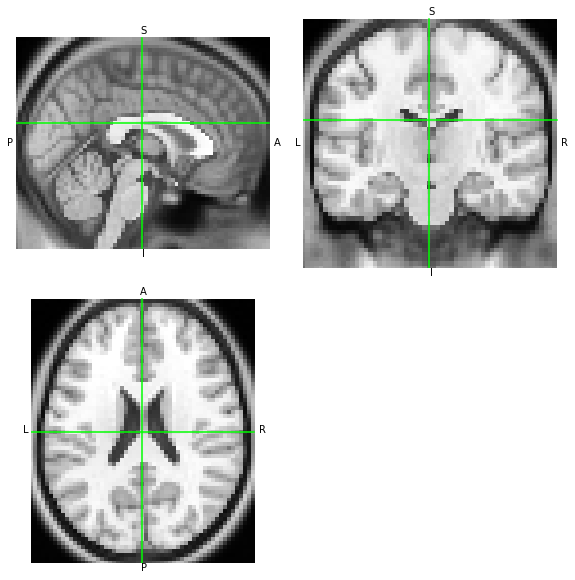

In [3]:
# Load the example
nii = nb.load('someones_anatomy.nii.gz')
hdr = nii.header.copy()
aff = nii.affine.copy()
data = np.asanyarray(nii.dataobj)
nii.orthoview()

### Generating variants
Playing with the affine header and the data array ordering of axes and elements we generate several versions of the dataset with different orientations (LAS, LPS, oblique, LPS oblique).

In [4]:
# Create LAS version
las_aff = aff.copy()
las_aff[0, 0] *= -1.0
las_aff[0, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[0]

las = nb.Nifti1Image(np.flip(data, 0), las_aff, nii.header)
las.to_filename('someones_anatomy_LAS.nii.gz')

# Create LPS version
lps_aff = aff.copy()
lps_aff[0, 0] *= -1.0
lps_aff[1, 1] *= -1.0
lps_aff[:2, 3] = aff.dot(np.hstack((np.array(nii.shape[:3]) - 1, 1.0)))[:2]

lps = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lps_aff, nii.header)
lps.to_filename('someones_anatomy_LPS.nii.gz')

# Create version not aligned to canonical
R = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.09, y=0.001, z=0.001))
M = R.dot(nii.affine)
new = nb.Nifti1Image(data, M, hdr)
new.header.set_qform(M, 1)
new.header.set_sform(M, 1)
new.to_filename('someones_anatomy_rot.nii.gz')

# Create version not aligned to canonical (LPS)
lpsM = R.dot(lps.affine)
lpsnew = nb.Nifti1Image(np.flip(np.flip(data, 0), 1), lpsM, hdr)
lpsnew.header.set_qform(lpsM, 1)
lpsnew.header.set_sform(lpsM, 1)
lpsnew.to_filename('someones_anatomy_lpsrot.nii.gz')

### Quick test with AFNI's `3dWarp -deoblique`
AFNI `3dWarp` comes with a `-deoblique` option that can be interesting to double check whether the examples above are useful.
This example checks whether our *oblique* image's version is perceived as such by AFNI, and *realign* it with the canonical axes.

In [28]:
!3dWarp -deoblique -prefix deob.nii.gz someones_anatomy_rot.nii.gz

++ 3dWarp: AFNI version=AFNI_16.0.01 (Jan 27 2016) [64-bit]
++ Authored by: RW Cox
** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_rot.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Using minimum spacing of 2.750000 mm for new grid spacing


AFNI stores the actual rotation matrices of the *deoblique* operation as NIfTI header extensions:

In [30]:
print(nb.load('deob.nii.gz').header.extensions[0].get_content().decode())

<?xml version='1.0' ?>
<AFNI_attributes
  self_idcode="XYZ_FCy7wA5HYblt6jagpbBVIA"
  NIfTI_nums="58,72,62,1,1,16"
  ni_form="ni_group" >
<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="HISTORY_NOTE" >
 "[oesteban@dendrite: Thu Nov 14 15:31:08 2019] 3dWarp -deoblique -prefix deob.nii.gz someones_anatomy_rot.nii.gz"
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_FOR_000000" >
 0.999999
 0.001085831
 0.0009060735
 -7.40746e-05
 -0.0009999992
 0.9959521
 -0.0898795
 -8.462602
 -0.0009999998
 0.0898785
 0.9959521
 -7.740018
</AFNI_atr>

<AFNI_atr
  ni_type="float"
  ni_dimen="12"
  atr_name="WARPDRIVE_MATVEC_INV_000000" >
 0.999999
 -0.0009999993
 -0.0009999998
 -0.01612854
 0.001085831
 0.9959522
 0.08987851
 9.124008
 0.0009060736
 -0.08987951
 0.9959523
 6.948074
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="TYPESTRING" >
 "3DIM_HEAD_ANAT"
</AFNI_atr>

<AFNI_atr
  ni_type="String"
  ni_dimen="1"
  atr_name="IDCODE_STRI

### Testing the variants with *NiTransforms*, *AFNI*, *ANTs*, and *FSL*, with a rigid-body transform
Now, let's use these variants to check how they affect in concatenation with other transforms

First, we check that, as *NiBabel* represents the data array disregarding the affine, the `.orthoview()` visualization of the *oblique* image shows the same apparent data orientation as for the original file.

<OrthoSlicer3D: someones_anatomy_rot.nii.gz (57, 67, 56)>

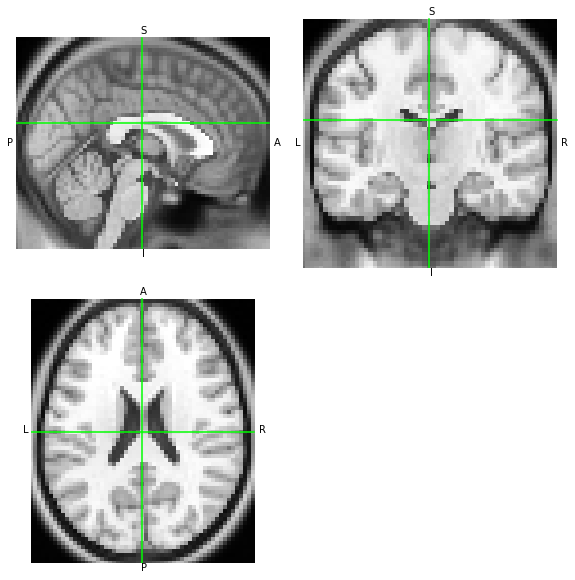

In [5]:
new.orthoview()

**Create a transform**. We test with a rigid-body transformation with 3 rotations and 3 translations

In [6]:
T = nb.affines.from_matvec(nb.eulerangles.euler2mat(x=0.9, y=0.001, z=0.001), [4.0, 2.0, -1.0])

#### *NiTransforms*
Let's resample the dataset using *NiTransforms*. This result should be similar with the other libraries.

In [7]:
xfm = nt.linear.Affine(T)
xfm.reference = new

In [8]:
moved = xfm.apply(new, order=0)
moved.to_filename('moved-nb.nii.gz')

<OrthoSlicer3D: moved-nb.nii.gz (57, 67, 56)>

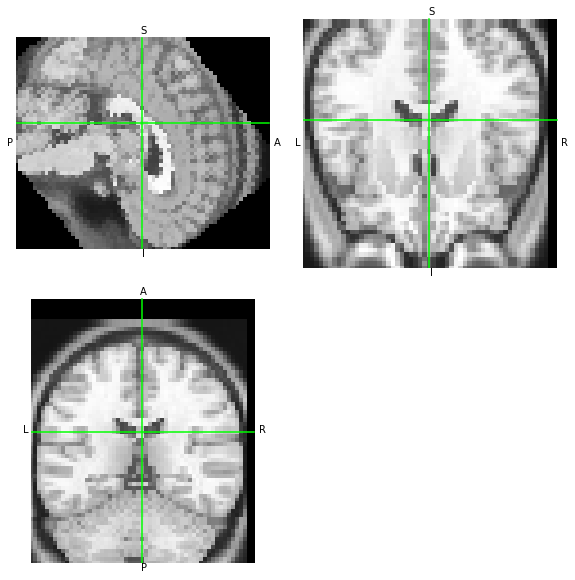

In [9]:
moved.orthoview()

**Store the transform in other formats**. Let's leverage *NiTransforms*' features to store the transforms for ANTs, FSL, and AFNI.

In [10]:
xfm.to_filename('M.tfm', fmt='itk')
xfm.to_filename('M.fsl', fmt='fsl')
xfm.to_filename('M.afni', moving=new, fmt='afni')

/home/oesteban/workspace/nitransforms/nitransforms/io/afni.py:183: UserWarning: Reference affine axes are oblique.
  warnings.warn('Reference affine axes are oblique.')
/home/oesteban/workspace/nitransforms/nitransforms/io/afni.py:191: UserWarning: Moving affine axes are oblique.
  warnings.warn('Moving affine axes are oblique.')


'M.afni'

#### Testing AFNI

<OrthoSlicer3D: (57, 67, 56)>

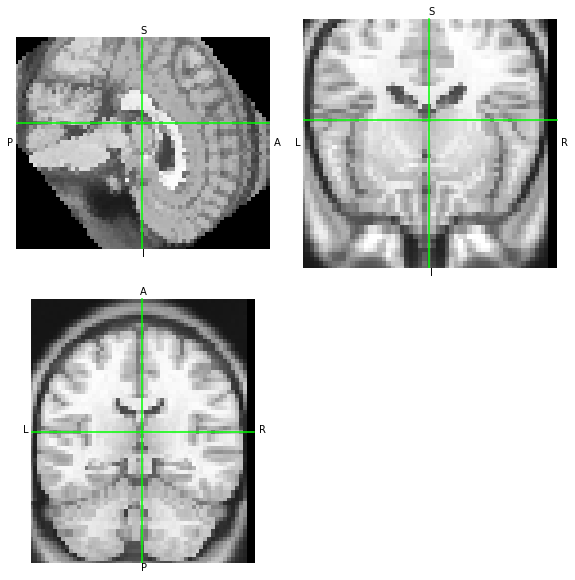

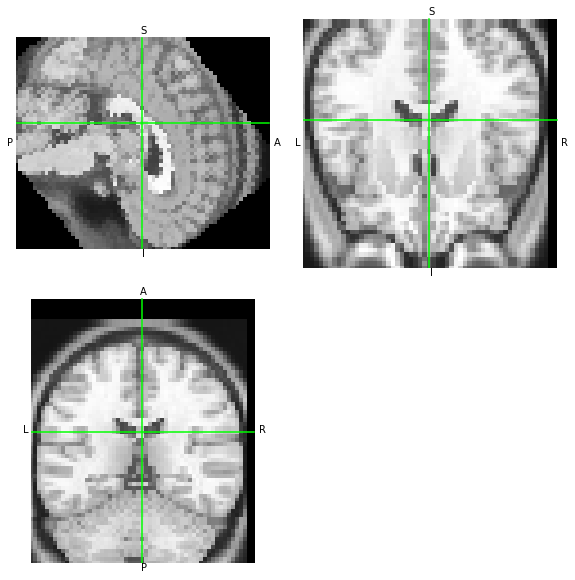

In [24]:
afnixfm = nt.io.afni.AFNILinearTransform.from_filename('M.afni')
xfm = nt.linear.Affine(afnixfm.to_ras(reference=new, moving=new), reference=new)
nt_with_afni = xfm.apply(new, order=0)
moved.orthoview()
nt_with_afni.orthoview()

++ 3dAllineate: AFNI version=AFNI_16.0.01 (Jan 27 2016) [64-bit]
++ Authored by: Zhark the Registrator
** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_rot.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
  such as someones_anatomy_rot.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Source dataset: ./someones_anatomy_rot.nii.gz
++ Base dataset:   ./someones_anatomy_rot.nii.gz
++ You might want to use '-master' when using '-1D*_apply'
++ Loading datasets
++ master datas

<OrthoSlicer3D: moved-nb.nii.gz (57, 67, 56)>

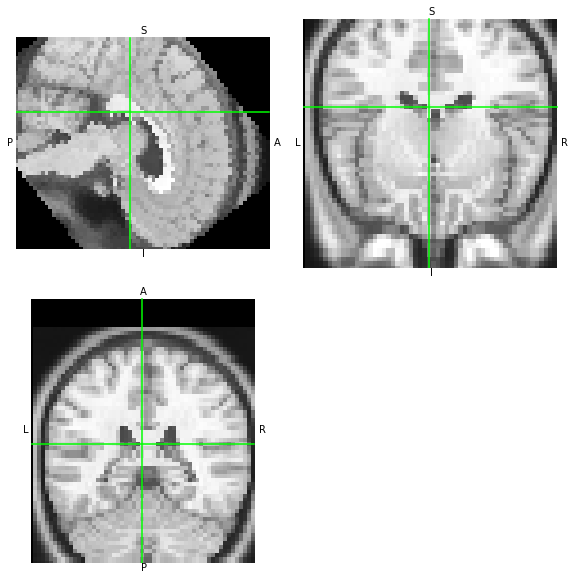

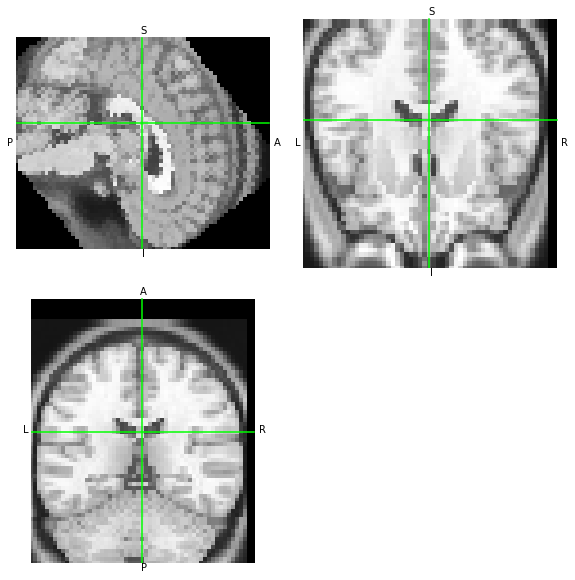

In [12]:
!3dAllineate -base someones_anatomy_rot.nii.gz -input someones_anatomy_rot.nii.gz -1Dmatrix_apply M.afni -prefix moved-afni.nii.gz -final NN
nb.load('moved-afni.nii.gz').orthoview()
moved.orthoview()

#### Testing ANTs/ITK

<OrthoSlicer3D: moved-itk.nii.gz (57, 67, 56)>

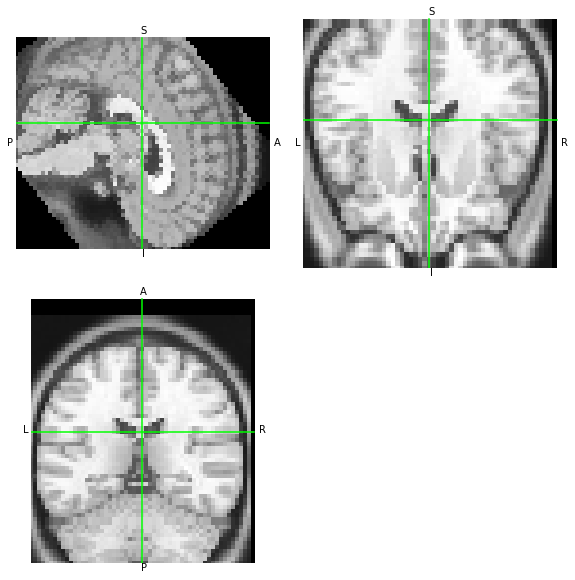

In [13]:
!antsApplyTransforms -d 3 -i 'someones_anatomy.nii.gz' -r 'someones_anatomy.nii.gz' -o 'moved-itk.nii.gz' -n 'NearestNeighbor' -t 'M.tfm' --float
nb.load('moved-itk.nii.gz').orthoview()

#### Testing FSL

<OrthoSlicer3D: moved-fsl.nii.gz (57, 67, 56)>

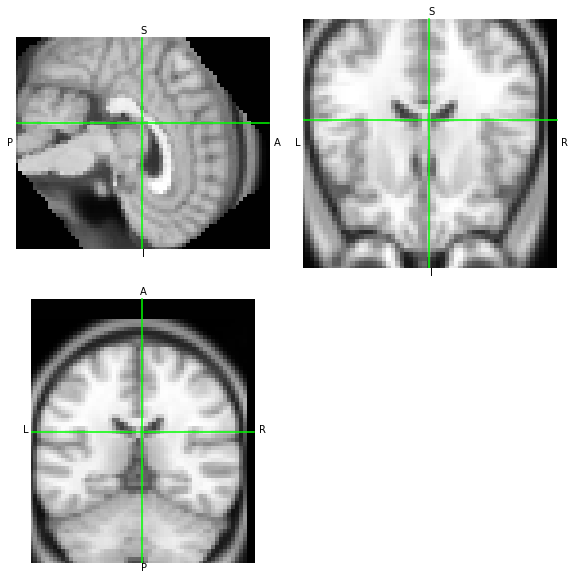

In [14]:
!flirt -in someones_anatomy.nii.gz -ref someones_anatomy.nii.gz -out moved-fsl.nii.gz -init M.fsl -applyxfm
nb.load('moved-fsl.nii.gz').orthoview()

## Annex: understanding AFNI's deoblique
The code in this section is just a preamble to the following notebook where we explore how AFNI implemented this operation.

In [35]:
from nibabel.affines import from_matvec
B = np.ones((2, 2))
AFNI_SIGNS = np.block([[B, -1.0 * B], [-1.0 * B, B]])

def _afni_warpdrive_for(oblique, plumb, inverse=False):
    """
    Calculate AFNI's ``WARPDRIVE_MATVEC_FOR_000000`` (de)obliquing affine.

    Parameters
    ----------
    oblique : 4x4 numpy.array
        affine that is not aligned to the cardinal axes.
    plumb : 4x4 numpy.array
        corresponding affine that is aligned to the cardinal axes.


    Returns
    -------
    plumb_to_oblique : 4x4 numpy.array
        the matrix that pre-pended to the plumb affine rotates it
        to be oblique.

    """
    R = np.linalg.inv(plumb[:3, :3]).dot(oblique[:3, :3])
    # origin = oblique[:3, 3] - R.dot(oblique[:3, 3])
    origin = np.zeros(3)
    return from_matvec(R, origin) * AFNI_SIGNS

In [37]:
afni_R = _afni_warpdrive_for(new.affine, nii.affine)
print(np.linalg.inv(afni_R))

[[ 9.99999000e-01  1.08583106e-03  9.06073535e-04  0.00000000e+00]
 [-9.99999333e-04  9.95952145e-01 -8.98795002e-02  0.00000000e+00]
 [-9.99999833e-04  8.98785043e-02  9.95952235e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<OrthoSlicer3D: moved-nb2.nii.gz (57, 67, 56)>

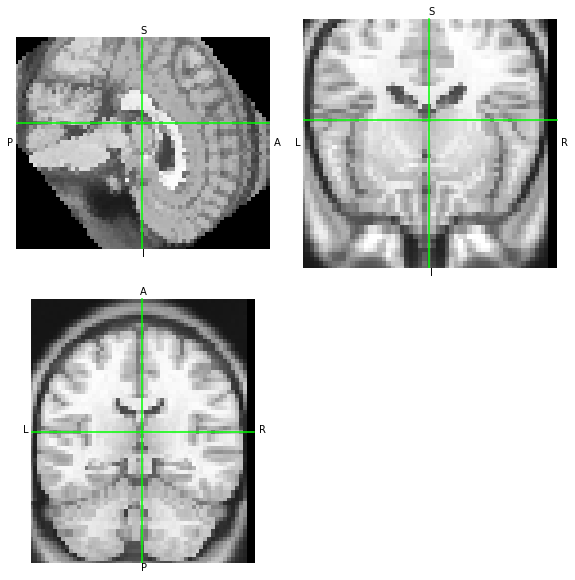

In [16]:
afni_R = _afni_deoblique(new.affine, nii.affine)
afni_T = np.linalg.inv(afni_R).dot(T.dot(afni_R))
xfm = nt.linear.Affine(afni_T)
xfm.reference = nii
xfm.to_filename('M2.afni', moving=nii, fmt='afni')
moved = xfm.apply(nii, order=0)
moved.to_filename('moved-nb2.nii.gz')
moved.orthoview()

++ 3dAllineate: AFNI version=AFNI_16.0.01 (Jan 27 2016) [64-bit]
++ Authored by: Zhark the Registrator
** AFNI converts NIFTI_datatype=2 (UINT8) in file someones_anatomy_rot.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
*+ WARNING:   If you are performing spatial transformations on an oblique dset, 
  such as someones_anatomy_rot.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Oblique dataset:someones_anatomy_rot.nii.gz is 5.156967 degrees from plumb.
++ Source dataset: ./someones_anatomy_rot.nii.gz
++ Base dataset:   ./someones_anatomy_rot.nii.gz
++ You might want to use '-master' when using '-1D*_apply'
++ Loading datasets
++ master datas

<OrthoSlicer3D: moved-nb2.nii.gz (57, 67, 56)>

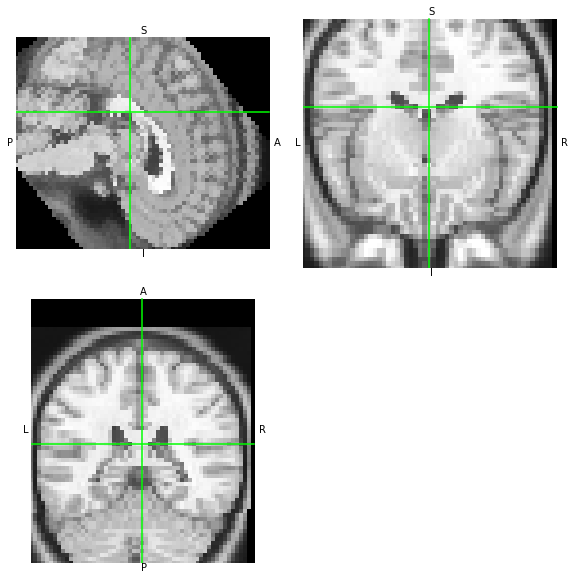

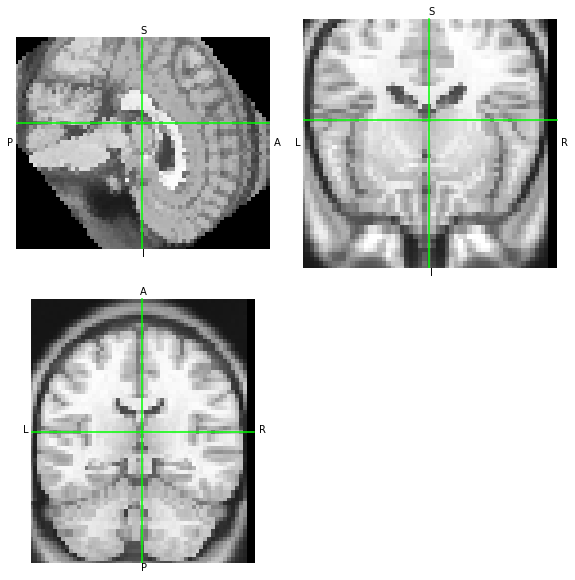

In [17]:
!3dAllineate -base someones_anatomy_rot.nii.gz -input someones_anatomy_rot.nii.gz -1Dmatrix_apply M2.afni -prefix moved-afni2.nii.gz -final nearest
nb.load('moved-afni2.nii.gz').orthoview()
moved.orthoview()